In [1]:
import numpy as np
import pandas as pd
import seaborn as sb


from transformers import TFAutoModel, AutoTokenizer, BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# TPU Setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync)

# Importing Train, Test Data

In [3]:
train_data = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_split = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
print("Train Split dimensions: ",train_data.shape)
print("Test Split dimensions: ",test_split.shape)

Train Split dimensions:  (12120, 6)
Test Split dimensions:  (5195, 5)


# Seperate English
#train_split = train_split[train_split['language'] == 'Engish']
is_english_train = train_split['language'] == 'English'
train_split = train_split[is_english_train]

is_english_test = test_split['language'] == 'English'
test_split = test_split[is_english_test]

In [4]:
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [5]:
train_data['premise'][0]

'and these comments were considered in formulating the interim rules.'

In [6]:
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


# Data Distribution

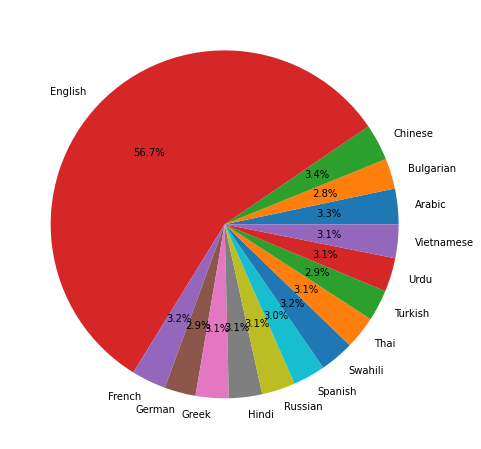

In [7]:
labels, frequencies = np.unique(train_data.language.values, return_counts = True)

plt.figure(figsize = (8,8))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [8]:
pd.DataFrame(list(zip(labels,frequencies)),columns =['Language', 'Count'])

,Language,Count
0,Arabic,401
1,Bulgarian,342
2,Chinese,411
3,English,6870
4,French,390
5,German,351
6,Greek,372
7,Hindi,374
8,Russian,376
9,Spanish,366


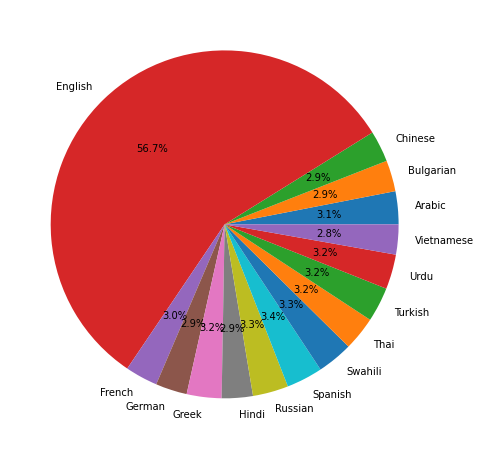

In [9]:
labels_test, frequencies_test = np.unique(test_split.language.values, return_counts = True)

plt.figure(figsize = (8,8))
plt.pie(frequencies_test,labels = labels_test, autopct = '%1.1f%%')
plt.show()

In [10]:
pd.DataFrame(list(zip(labels_test,frequencies_test)),columns =['Language', 'Count'])

,Language,Count
0,Arabic,159
1,Bulgarian,150
2,Chinese,151
3,English,2945
4,French,157
5,German,152
6,Greek,168
7,Hindi,150
8,Russian,172
9,Spanish,175


<AxesSubplot:xlabel='count', ylabel='label'>

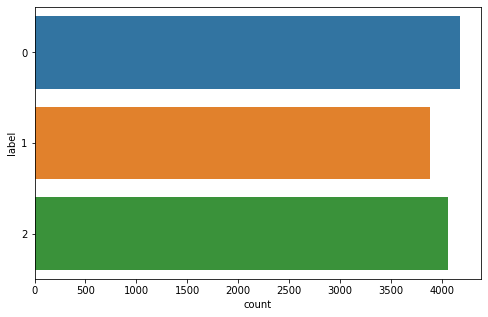

In [11]:
plt.figure(figsize=(8,5))
sb.countplot(y ='label', data = train_data)

<AxesSubplot:xlabel='count', ylabel='language'>

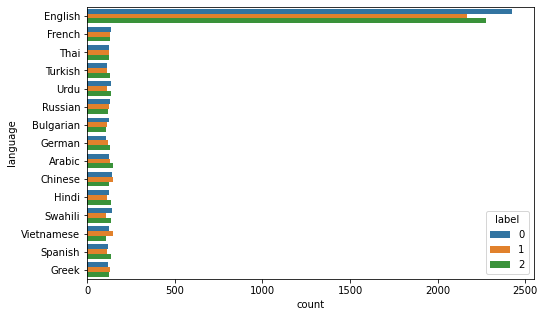

In [12]:
plt.figure(figsize=(8,5))
sb.countplot(y ='language', hue = "label", data = train_data)

# Data Split
Spliting data into Train and Valid splits having similar distributions among the languages

In [13]:
all_languages = train_data['language'].unique()
train_columns = list(train_data.columns)

In [14]:
validation_portion = 0.2
train_split = pd.DataFrame(columns = train_columns)
valid_split = pd.DataFrame(columns = train_columns)

for language in all_languages:
    lang_filter = (train_data['language'] == language)
    
    filtered_df = train_data[lang_filter]
    
    lang_count = len(filtered_df)
    valid_count = round(lang_count * 0.2)
    print(language, " : ",valid_count)
    #print(filtered_df.iloc[0:valid_count])
    
    valid_split = valid_split.append(
        filtered_df.iloc[0:valid_count],
        ignore_index = True
    )
    train_split = train_split.append(
        filtered_df.iloc[valid_count:],
        ignore_index = True
    )
    
train_split = train_split.sample(frac=1).reset_index(drop=True)
valid_split = valid_split.sample(frac=1).reset_index(drop=True)

English  :  1374
French  :  78
Thai  :  74
Turkish  :  70
Urdu  :  76
Russian  :  75
Bulgarian  :  68
German  :  70
Arabic  :  80
Chinese  :  82
Hindi  :  75
Swahili  :  77
Vietnamese  :  76
Spanish  :  73
Greek  :  74


## Train Split

In [15]:
train_split

,id,premise,hypothesis,lang_abv,language,label
0,fc291c20a8,and uh it that takes so much time away from yo...,Leaves you with plenty of time for your kids.,en,English,2
1,7db00bdd49,"Obwohl diese Idee, diesen Bereich der Forschun...",Den Bereich hervorzuheben hat keinen Wert.,de,German,2
2,6a6b70754d,"लेकिन मैं जैसे कि यह भूल गया था, कि मैं दोपहर ...",मुझे भूख लगी थी इसलिए मैंने अपना दोपहर का भोजन...,hi,Hindi,0
3,e49317338d,While headquarters staffing is to be streamlin...,Headquarters staff is increased and port staff...,en,English,2
4,8ec151d865,It is nice to be reminded that people remember.,It is nice that people remember.,en,English,0
...,...,...,...,...,...,...
9693,16729fddd4,Hay muchas otras opciones culturales y artísti...,El Teatro Cívico se encuentra en el centro de ...,es,Spanish,1
9694,4413f1c6b6,"The gardens are among the greatest in Europe, ...",The gardens have more varieties of flowers tha...,en,English,1
9695,3636c3810c,"एक मिनट वह मेज को पीट रहा था, दूसरे में वह ठीक...",वह अपने निश्चय को बदलता है क्योंकि वह नहीं जान...,hi,Hindi,1
9696,4a84e70cfb,"This time around, Lloyd believes he's the Mess...","But this time, Lloyd thinks of himself as the ...",en,English,0


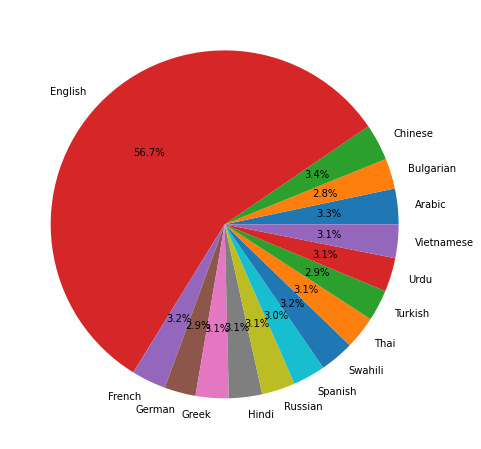

In [16]:
labels_train, frequencies_train = np.unique(train_split.language.values, return_counts = True)

plt.figure(figsize = (8,8))
plt.pie(frequencies_train,labels = labels_train, autopct = '%1.1f%%')
plt.show()

In [17]:
pd.DataFrame(list(zip(labels_train,frequencies_train)),columns =['Language', 'Count'])

,Language,Count
0,Arabic,321
1,Bulgarian,274
2,Chinese,329
3,English,5496
4,French,312
5,German,281
6,Greek,298
7,Hindi,299
8,Russian,301
9,Spanish,293


<AxesSubplot:xlabel='count', ylabel='label'>

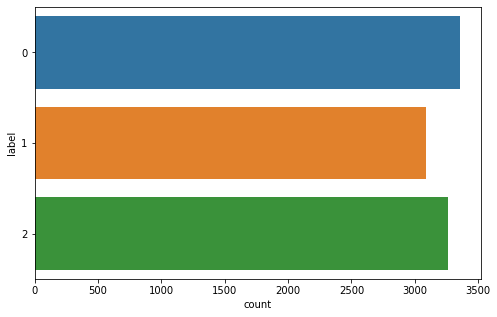

In [18]:
plt.figure(figsize=(8,5))
sb.countplot(y ='label', data = train_split)

<AxesSubplot:xlabel='count', ylabel='language'>

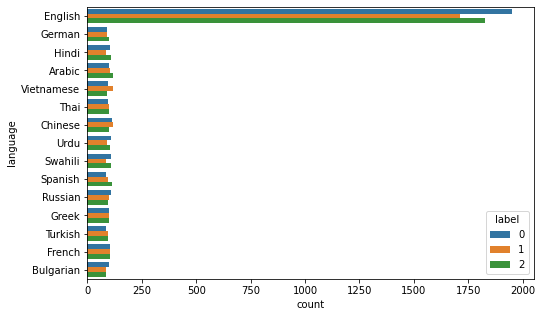

In [19]:
plt.figure(figsize=(8,5))
sb.countplot(y ='language', hue = "label", data = train_split)

In [20]:
train_data.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [21]:
train_split.head()

,id,premise,hypothesis,lang_abv,language,label
0,fc291c20a8,and uh it that takes so much time away from yo...,Leaves you with plenty of time for your kids.,en,English,2
1,7db00bdd49,"Obwohl diese Idee, diesen Bereich der Forschun...",Den Bereich hervorzuheben hat keinen Wert.,de,German,2
2,6a6b70754d,"लेकिन मैं जैसे कि यह भूल गया था, कि मैं दोपहर ...",मुझे भूख लगी थी इसलिए मैंने अपना दोपहर का भोजन...,hi,Hindi,0
3,e49317338d,While headquarters staffing is to be streamlin...,Headquarters staff is increased and port staff...,en,English,2
4,8ec151d865,It is nice to be reminded that people remember.,It is nice that people remember.,en,English,0


## Validation Split

In [22]:
valid_split

,id,premise,hypothesis,lang_abv,language,label
0,fa33f24477,No se puede decir lo mismo para el New York Ti...,El Times dijo que Bush había mentido anteriorm...,es,Spanish,1
1,9d7a2c3acd,but i've lived up here all my life and i'm fif...,I have my family here living with me.,en,English,1
2,fc90356a4a,کیا یہ بیس فیصد سود ہے؟,کوۂی انٹرسٹ نہیں ہے,ur,Urdu,2
3,7cf8762f15,"See you Aug. 12, or soon thereafter, we hope.",The person was going to attend on August 12.,en,English,1
4,042626ee07,Hậu quả cuối cùng của sự từ chức của Livingsto...,Việc Livingston từ chức dường như đã khiến tổn...,vi,Vietnamese,0
...,...,...,...,...,...,...
2417,03c7c4e5b1,مجھے ڈیل ڑیو جانے کا حکم دیا گیا تھا ، جب وہاں...,ایئر فورس نے مجھ کو 2001 میں ڈیل ریو‏، ٹیکساس ...,ur,Urdu,1
2418,701a4aa787,"Öyle duydum, diye kabullendi kısık bir sesle.",Bir şey duymuştu.,tr,Turkish,0
2419,27d24d468a,We know essentially nothing about life beyond ...,We don't know anything about life past Earth.,en,English,0
2420,69e64a94f1,यदि घरों की मौजूदा परिसंपत्तियों का मूल्य घटता...,यदि घरों की संपत्तियों का मूल्य कम हो जाता है ...,hi,Hindi,2


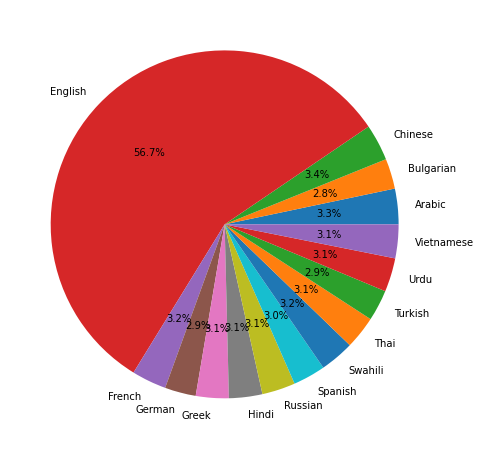

In [23]:
labels_valid, frequencies_valid = np.unique(valid_split.language.values, return_counts = True)

plt.figure(figsize = (8,8))
plt.pie(frequencies_valid,labels = labels_valid, autopct = '%1.1f%%')
plt.show()

In [24]:
pd.DataFrame(list(zip(labels_valid,frequencies_valid)),columns =['Language', 'Count'])

,Language,Count
0,Arabic,80
1,Bulgarian,68
2,Chinese,82
3,English,1374
4,French,78
5,German,70
6,Greek,74
7,Hindi,75
8,Russian,75
9,Spanish,73


<AxesSubplot:xlabel='count', ylabel='label'>

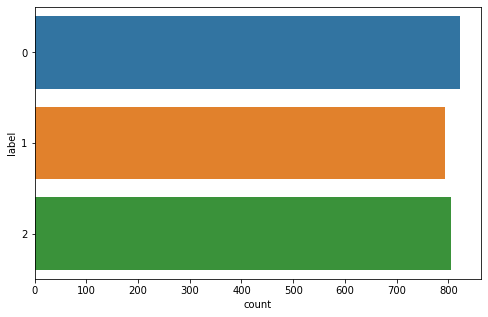

In [25]:
plt.figure(figsize=(8,5))
sb.countplot(y ='label', data = valid_split)

<AxesSubplot:xlabel='count', ylabel='language'>

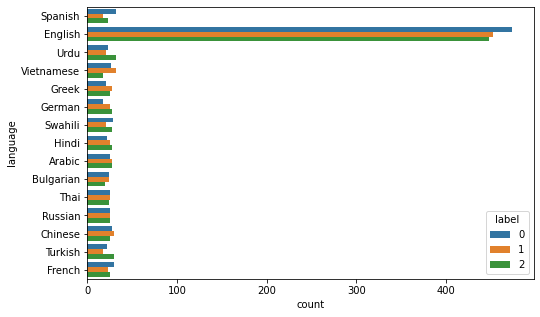

In [26]:
plt.figure(figsize=(8,5))
sb.countplot(y ='language', hue = "label", data = valid_split)

# Data Split Sizes

In [27]:
print("Train Split: ",train_split.shape)
print("Valid Split: ",valid_split.shape)
print("Test Split: ",test_split.shape)

Train Split:  (9698, 6)
Valid Split:  (2422, 6)
Test Split:  (5195, 5)


# Data Preperation

In [28]:
roberta_name = 'joeddav/xlm-roberta-large-xnli'
# xlnet-base-cased
#roberta_name = 'roberta-large-mnli'
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)

# roberta-large-mnli
#bert_name = 'bert-base-multilingual-cased'
bert_name = 'roberta-large-mnli'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [29]:
def encode_sentence(in_text, tokenizer):
    tokens = list(tokenizer.tokenize(in_text))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [30]:
encode_sentence("I love Quantum Machine Learning", roberta_tokenizer)

[87, 5161, 75344, 316, 68311, 114344, 3]

In [31]:
def encode_sentences(hypotheses, premises, tokenizer):
    num_examples = len(hypotheses)
  
    sentenceHypotheses = tf.ragged.constant([
        encode_sentence(s, tokenizer) 
        for s in np.array(hypotheses)
    ])

    sentencePremises = tf.ragged.constant([
        encode_sentence(s, tokenizer)
        for s in np.array(premises)
    ])
    

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentenceHypotheses.shape[0]
    input_word_ids = tf.concat([cls, sentenceHypotheses, sentencePremises], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentenceHypotheses)
    type_s2 = tf.ones_like(sentencePremises)
    
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    return inputs

In [32]:
def tokenize_sentences(in_text, tokenizer, max_len):
    
    PAD_ID = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
 
    # Separator for each sentence
    tokens1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in in_text[0]], dtype=tf.int32) 
    tokens2 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in in_text[1]], dtype=tf.int32)
    
    # Tokenization
    cls_label = [tokenizer.convert_tokens_to_ids([tokenizer.cls_token])]*tokens1.shape[0]
    
    # Concatenation
    tokens = tf.concat([cls_label, tokens1, tokens2], axis=-1)

    # Truncating to max_len.
    tokens = tokens[:, :max_len]

    # Padding with zeroes for sentence length < max_len.
    tokens = tokens.to_tensor(default_value=PAD_ID)
    pad = max_len - tf.shape(tokens)[1]
    tokens = tf.pad(tokens, [[0, 0], [0, pad]], constant_values=PAD_ID)
    
    
    input_word_ids = tf.reshape(tokens, [-1, max_len])

    # The input mask to differentiate between training content vs. added padding. 
    input_mask = tf.cast(input_word_ids != PAD_ID, tf.int32)
    input_mask = tf.reshape(input_mask, [-1, max_len])

    # Map tokens1 to 0s and tokens2 to 1s.
    input_type_ids = tf.concat([tf.zeros_like(cls_label), tf.zeros_like(tokens1), tf.ones_like(tokens2)], axis=-1).to_tensor()
    input_type_ids = input_type_ids[:, :max_len] # Truncating to max_len.


    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [33]:
train_hypothesis_sentences = train_split.hypothesis.values
train_premise_sentences = train_split.premise.values

valid_hypothesis_sentences = valid_split.hypothesis.values
valid_premise_sentences = valid_split.premise.values

In [34]:
max_length = 120
# Need to have another one for bert !!!!!!!!!!! <===============
train_split_encoded_rob = tokenize_sentences([train_hypothesis_sentences, train_premise_sentences], roberta_tokenizer, max_length)
train_split_encoded_bert = tokenize_sentences([train_hypothesis_sentences, train_premise_sentences], bert_tokenizer, max_length)
train_labels = train_split.label.values.astype('int')

valid_split_encoded_rob = tokenize_sentences([valid_hypothesis_sentences, valid_premise_sentences], roberta_tokenizer, max_length)
valid_split_encoded_bert = tokenize_sentences([valid_hypothesis_sentences, valid_premise_sentences], bert_tokenizer, max_length)
valid_labels = valid_split.label.values.astype('int')

In [35]:
from tensorflow.keras import Input, Model, optimizers
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [36]:
def build_model(max_len = max_length):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    roberta_encoder = TFAutoModel.from_pretrained(roberta_name) # Pretrained Encoder
    embedding_layer = roberta_encoder([input_word_ids, input_mask, input_type_ids])[0]
    #embedding_layer = roberta_encoder([input_word_ids, input_mask])[0]
    
    output = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    
    output = Dense(3, activation='softmax')(output)
    
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    #model = Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # sparse_categorical_crossentropy
    
    return model

In [37]:
with strategy.scope():
    model = build_model()
    model.summary()

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

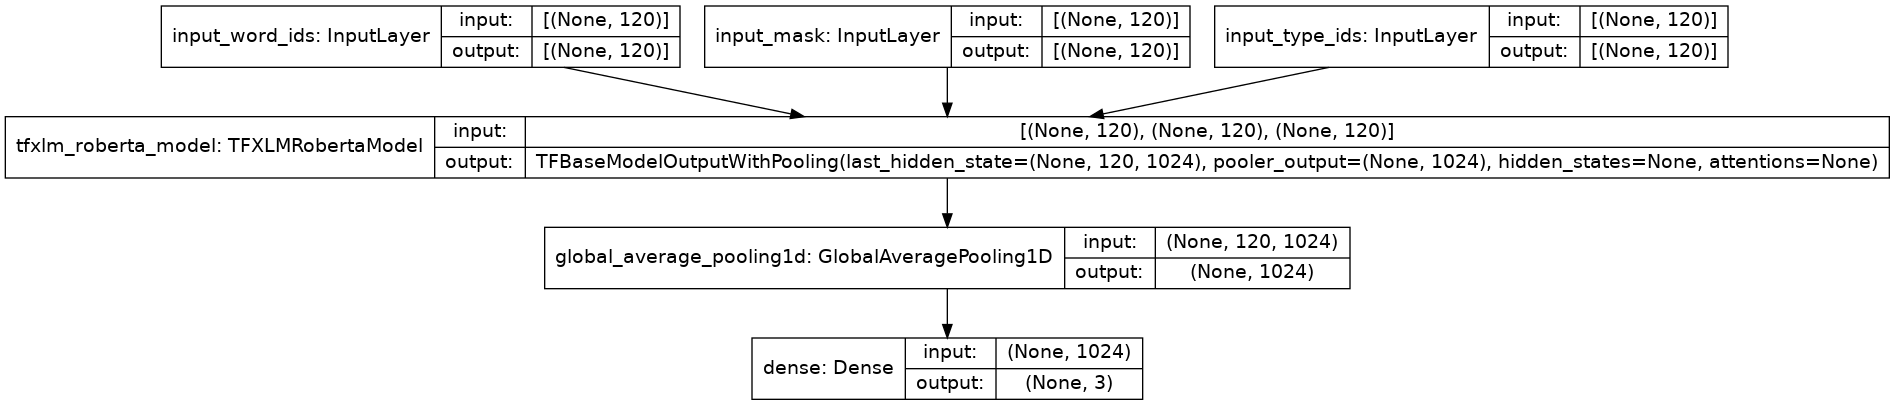

In [38]:
tf.keras.utils.plot_model(model, "hybrid_model.png", show_shapes=True)

In [39]:
batch_size = strategy.num_replicas_in_sync * 16
epochs = 5

print("Epochs: ",epochs, " | Batch Size: " ,batch_size)

Epochs:  5  | Batch Size:  128


In [40]:
callback_earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

In [41]:
callback_reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=1, verbose=1, mode='min',
    min_delta=0.001, cooldown=1, min_lr=0.000001
)

In [42]:
model.fit(train_split_encoded_rob, train_labels, 
          epochs = epochs,
          #steps_per_epoch = 77,
          verbose = 1, 
          batch_size = batch_size,
          callbacks = [callback_earlystop, callback_reduce_lr],
          validation_data = (valid_split_encoded_rob, valid_labels)) # Max Val accuracy - only english = 0.8486

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


76/76 [==============================] - 261s 2s/step - loss: 0.7540 - accuracy: 0.6477 - val_loss: 0.4107 - val_accuracy: 0.8410
Epoch 2/5
76/76 [==============================] - 21s 272ms/step - loss: 0.3292 - accuracy: 0.8767 - val_loss: 0.3620 - val_accuracy: 0.8699
Epoch 3/5
76/76 [==============================] - 21s 272ms/step - loss: 0.1885 - accuracy: 0.9318 - val_loss: 0.4136 - val_accuracy: 0.8836

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 4/5
76/76 [==============================] - 21s 271ms/step - loss: 0.1105 - accuracy: 0.9608 - val_loss: 0.4275 - val_accuracy: 0.8865
Epoch 5/5
76/76 [==============================] - 21s 272ms/step - loss: 0.0855 - accuracy: 0.9721 - val_loss: 0.4414 - val_accuracy: 0.8889


## Validation Test Training

In [43]:
K.set_value(model.optimizer.learning_rate, 0.5e-5)
model.fit(valid_split_encoded_rob, valid_labels, 
          epochs = 1,
          #steps_per_epoch = 77,
          verbose = 1,
          callbacks = None,
          batch_size = batch_size)

19/19 [==============================] - 88s 5s/step - loss: 0.3755 - accuracy: 0.8675


# Model 2

In [44]:
def build_model_0(max_len = max_length):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    roberta_encoder = TFAutoModel.from_pretrained(bert_name) # Pretrained Encoder
    embedding_layer = roberta_encoder([input_word_ids, input_mask, input_type_ids])[0]
    #embedding_layer = roberta_encoder([input_word_ids, input_mask])[0]
    
    output = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    
    output = Dense(3, activation='softmax')(output)
    
    model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    #model = Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # sparse_categorical_crossentropy
    

    return model

In [45]:
with strategy.scope():
    model_0 = build_model_0()
    model_0.summary()

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large-mnli were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large-mnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 355359744   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [59]:
model_0.fit(train_split_encoded_bert, train_labels, 
          epochs = epochs*2,
          verbose = 1, 
          batch_size = batch_size,
          callbacks = [callback_earlystop, callback_reduce_lr],
          validation_data = (valid_split_encoded_bert, valid_labels))

Epoch 1/5
76/76 [==============================] - 18s 240ms/step - loss: 0.4451 - accuracy: 0.7762 - val_loss: 0.5558 - val_accuracy: 0.7436
Epoch 2/5
76/76 [==============================] - 18s 240ms/step - loss: 0.4100 - accuracy: 0.7887 - val_loss: 0.5990 - val_accuracy: 0.7481

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1e-06.
Epoch 3/5
76/76 [==============================] - 18s 240ms/step - loss: 0.3803 - accuracy: 0.8088 - val_loss: 0.6011 - val_accuracy: 0.7498
Epoch 4/5
76/76 [==============================] - 18s 240ms/step - loss: 0.3702 - accuracy: 0.8140 - val_loss: 0.6168 - val_accuracy: 0.7494
Epoch 5/5
76/76 [==============================] - 18s 241ms/step - loss: 0.3641 - accuracy: 0.8182 - val_loss: 0.6307 - val_accuracy: 0.7498


In [60]:
K.set_value(model_0.optimizer.learning_rate, 0.5e-5)
model_0.fit(valid_split_encoded_bert, valid_labels, 
          epochs =1,
          #steps_per_epoch = 77,
          verbose = 1,
          callbacks = None,
          batch_size = batch_size)

19/19 [==============================] - 4s 221ms/step - loss: 0.6018 - accuracy: 0.7271


In [61]:
test_hypothesis_sentences = test_split.hypothesis.values
test_premise_sentences = test_split.premise.values

In [62]:
test_split_encoded_rob = tokenize_sentences([test_hypothesis_sentences, test_premise_sentences], roberta_tokenizer, max_length)
test_split_encoded_bert = tokenize_sentences([test_hypothesis_sentences, test_premise_sentences], bert_tokenizer, max_length)

In [63]:
def get_ensemble_max(encoded_in_0,encoded_in_1,model_0,model_1):
    return np.max([model_0.predict(encoded_in_0),model_1.predict(encoded_in_1)], axis=0)

In [64]:
def get_ensemble_mean(encoded_in_0,encoded_in_1,model_0,model_1):
    return np.mean([model_0.predict(encoded_in_0),model_1.predict(encoded_in_1)], axis=0)

In [65]:
test_predictions_max = [np.argmax(i) for i in get_ensemble_max(test_split_encoded_rob, test_split_encoded_bert,model,model_0)]
test_predictions_mean = [np.argmax(i) for i in get_ensemble_mean(test_split_encoded_rob, test_split_encoded_bert,model,model_0)]


In [66]:
test_predictions_mean[0:5]

[2, 1, 0, 1, 1]

# Submission

In [67]:
submission_max = test_split.id.copy().to_frame()
submission_max['prediction'] = test_predictions_max

submission_mean = test_split.id.copy().to_frame()
submission_mean['prediction'] = test_predictions_mean

In [68]:
submission_max

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,0
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


In [69]:
submission_mean

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,0
5191,f357a04e86,2
5192,1f0ea92118,0
5193,0407b48afb,0


In [70]:
submission_max.to_csv("submission.csv", index = False)

In [71]:
submission_mean.to_csv("mean_submission.csv", index = False)